In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from torchvision_datasets import PACS
# !pip install torchdatasets


In [60]:
batch_size = 128
epochs = 5
lr = 0.001
lambda_irm = 0.5

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [97]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F

# Function to manually rotate images to specific angles
def rotate_image(image, angle):
    return F.rotate(image, angle)

# Create a rotated MNIST dataset with specific angles for each environment
def create_rotated_mnist(rotation_angle, train, subset_start, subset_size):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: rotate_image(img, rotation_angle)),  # Apply fixed rotation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    mnist = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    
    if train:
        # Create a subset of 10,000 samples from the training data
        subset_indices = list(range(subset_start, subset_size))
        mnist = Subset(mnist, subset_indices)
    
    return DataLoader(mnist, batch_size=128, shuffle=True)

# Creating training environments with fixed rotations
train_envs = [
    create_rotated_mnist(15, True, 0, 10000),  # Rotate by 15 degrees
    # create_rotated_mnist(30),  # Rotate by 30 degrees
    # create_rotated_mnist(45, True, 0, 10000),  # Rotate by 45 degrees
    # create_rotated_mnist(60, True, 0, 10000),   # Rotate by 60 degrees
    # create_rotated_mnist(75, True, 0, 10000),
    # create_rotated_mnist(90, True, 0, 10000)
]

val_env = create_rotated_mnist(60, True, 12000, 22000)

# Create the test environment (rotate by 75 to 90 degrees)
test_env = create_rotated_mnist(0, False, 0, 10000)


In [98]:
# Print the length of datasets and total batches
print("=== Dataset Information ===")
for i, train_env in enumerate(train_envs):
    num_samples = len(train_env.dataset)
    num_batches = len(train_env)
    print(f"Training Environment {i+1}:")
    print(f" - Total Samples: {num_samples}")
    print(f" - Total Batches: {num_batches}")

num_val_samples = len(val_env.dataset)
num_val_batches = len(val_env)
print("\nVal Environment:")
print(f" - Total Samples: {num_val_samples}")
print(f" - Total Batches: {num_val_batches}")
num_test_samples = len(test_env.dataset)
num_test_batches = len(test_env)
print("\nTest Environment:")
print(f" - Total Samples: {num_test_samples}")
print(f" - Total Batches: {num_test_batches}")


=== Dataset Information ===
Training Environment 1:
 - Total Samples: 10000
 - Total Batches: 79

Val Environment:
 - Total Samples: 10000
 - Total Batches: 79

Test Environment:
 - Total Samples: 10000
 - Total Batches: 79


Total number of dataloaders: 2


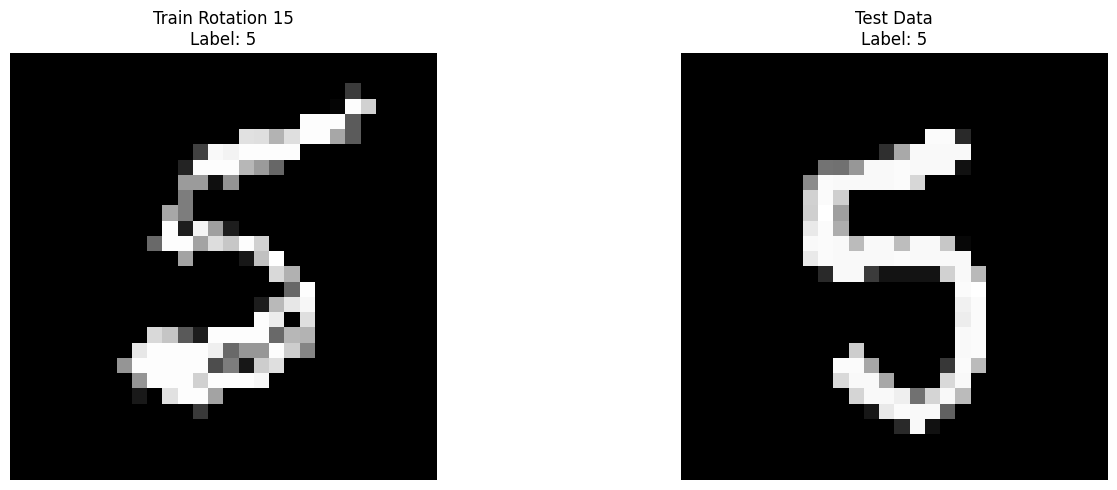

In [104]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Helper function to filter a specific digit
def filter_digit(dataloader, digit):
    for images, labels in dataloader:
        mask = labels == digit
        if mask.sum() > 0:
            return images[mask][:1], labels[mask][:1]  # Return first instance of the digit
    return None, None

# Helper function to visualize data samples
def visualize_filtered_digit(dataloaders, titles, digit):
    fig, axes = plt.subplots(1, len(dataloaders), figsize=(15, 5))
    for i, (dataloader, title) in enumerate(zip(dataloaders, titles)):
        image, label = filter_digit(dataloader, digit)
        if image is not None:
            image_grid = make_grid(image, nrow=1)
            axes[i].imshow(image_grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
            axes[i].set_title(f"{title}\nLabel: {label.item()}")
        else:
            axes[i].set_title(f"{title}\nNo data found")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Assuming `train_envs` and `test_env` have been defined with fixed rotations:
# Visualizing the digit with different rotations and in the test set
digit_to_visualize = 5
train_titles = [f"Train Rotation {15}" for i in range(1)]
dataloader_titles = train_titles + ["Test Data"]
dataloaders = train_envs + [test_env]

# Print the number of dataloaders (train + test)
print(f"Total number of dataloaders: {len(dataloaders)}")

# Visualizing the filtered digit from the dataloaders
visualize_filtered_digit(dataloaders, dataloader_titles, digit_to_visualize)


In [65]:
# # Model: ResNet18 adapted for grayscale (1-channel) input
# class ResNetDG(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNetDG, self).__init__()
#         self.base_model = models.resnet18(pretrained=True)
#         # Modify the first layer to accept 1-channel input
#         self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.base_model(x)

        
class SimpleIRMModel(nn.Module):
    def __init__(self):
        super(SimpleIRMModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

# Initialize model, optimizer, and loss
model = SimpleIRMModel().to(device)

In [66]:
# IRM Penalty (same function as before)
from tqdm import tqdm

def evaluate_on_env(model, env, device):
    model.eval()
    total_correct, total_samples = 0, 0
    epoch_loss = 0.0
    
    with torch.no_grad():
        with tqdm(total=len(env), desc="Evaluating", unit="batch") as pbar_eval:
            for images, labels in env:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                erm_loss = nn.CrossEntropyLoss()(logits, labels)
                epoch_loss += erm_loss.item()
                total_correct += (logits.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)
                pbar_eval.update(1)
    
    accuracy = total_correct / total_samples
    return accuracy, epoch_loss / total_samples

def irm_penalty(logits, labels):
    scale = torch.tensor(1.0, requires_grad=True).to(logits.device)
    loss = nn.CrossEntropyLoss()(logits * scale, labels)
    grad = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad ** 2)

# Training Function (same function as before)
def train_irm_basic(model, train_envs, test_env, epochs, lr, lambda_irm):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    iid_accuracies, ood_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_penalty = 0.0
        total_correct_iid, total_samples_iid = 0, 0

        print(f"Epoch {epoch+1}/{epochs}")
        with tqdm(total=sum(len(env) for env in train_envs), desc="Training", unit="batch") as pbar:
            for env in train_envs:
                for images, labels in env:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    logits = model(images)
                    
                    # IRM Loss
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)
                    penalty = irm_penalty(logits, labels)
                    loss = erm_loss + lambda_irm * penalty
                    loss.backward()
                    optimizer.step()

                    # Metrics
                    epoch_loss += loss.item()
                    epoch_penalty += penalty.item()
                    # total_correct_iid += (logits.argmax(1) == labels).sum().item()
                    # total_samples_iid += labels.size(0)
                    
                    # Update progress bar
                    pbar.update(1)
                    pbar.set_postfix(
                        loss=f"{loss.item():.4f}",
                        penalty=f"{penalty.item():.4f}"
                    )

        # Compute IID Accuracy
        # iid_accuracy = total_correct_iid / total_samples_iid
        val_accuracy, val_loss = evaluate_on_env(model, val_env, device)
        
        iid_accuracies.append(val_accuracy)

        # Evaluate on test data (OOD)
        model.eval()
        total_correct_ood, total_samples_ood = 0, 0
        epoch_test_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(test_env), desc="Evaluating", unit="batch") as pbar_eval:
                for images, labels in test_env:
                    images, labels = images.to(device), labels.to(device)
                    logits = model(images)
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)
                    epoch_test_loss += erm_loss.item()
                    total_correct_ood += (logits.argmax(1) == labels).sum().item()
                    total_samples_ood += labels.size(0)
                    pbar_eval.update(1)

        ood_accuracy = total_correct_ood / total_samples_ood
        ood_accuracies.append(ood_accuracy)

        # Print epoch summary
        print(
            f"Epoch {epoch+1} Summary:\n"
            f"IID Accuracy: {val_accuracy:.4f}, OOD Accuracy: {ood_accuracy:.4f}\n"
            f"Train Loss: {val_loss:.4f}\n"
            f"Test Loss: {epoch_test_loss/total_samples_ood:.4f}"
        )

    return iid_accuracies, ood_accuracies

In [87]:
# Initialize model and train IRM Basic
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleIRMModel().to(device)
# model = SmallCNN()
epochs = 5
iid_accuracies_BASIC, ood_accuracies_BASIC = train_irm_basic(model, train_envs, test_env, epochs, lr, lambda_irm)

Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.16batch/s]


Epoch 1 Summary:
IID Accuracy: 0.8514, OOD Accuracy: 0.1527
Train Loss: 0.0037
Test Loss: 0.0374
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 39.64batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8777, OOD Accuracy: 0.1931
Train Loss: 0.0030
Test Loss: 0.0349
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.90batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8785, OOD Accuracy: 0.2053
Train Loss: 0.0028
Test Loss: 0.0328
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.83batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9154, OOD Accuracy: 0.2180
Train Loss: 0.0021
Test Loss: 0.0354
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.63batch/s]

Epoch 5 Summary:
IID Accuracy: 0.9326, OOD Accuracy: 0.2257
Train Loss: 0.0017
Test Loss: 0.0337


In [68]:
# # Initialize model and train IRM Basic
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model = SmallCNN()
# epochs = 5
# iid_accuracies_BASIC, ood_accuracies_BASIC = train_irm_basic(model, train_envs, test_env, epochs, lr, lambda_irm)

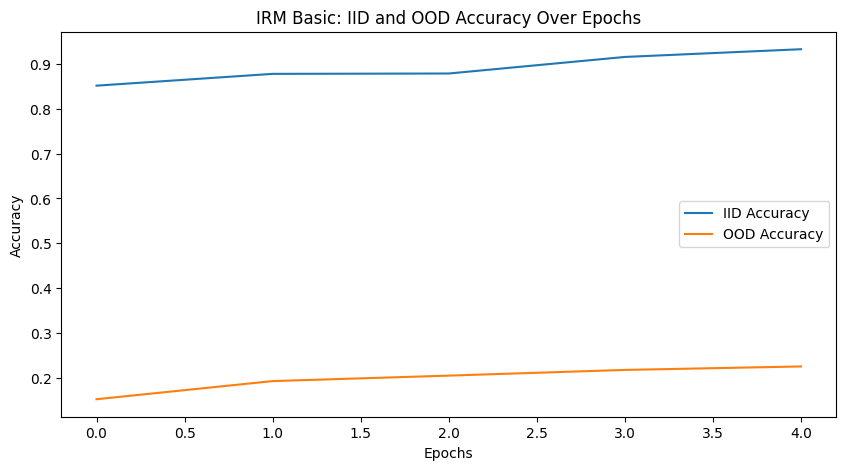

/tmp/ipykernel_23/1982829255.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Epochs")


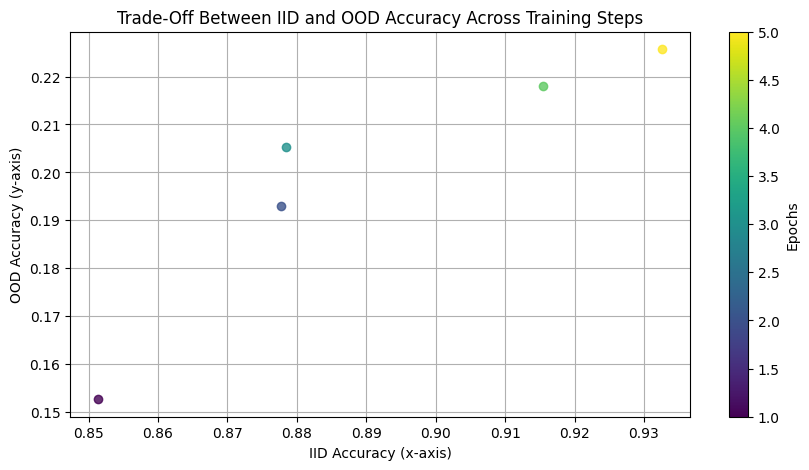

In [88]:
# Plot Results: IID vs OOD Accuracy
plt.figure(figsize=(10, 5))
plt.plot(iid_accuracies_BASIC, label='IID Accuracy')
plt.plot(ood_accuracies_BASIC, label='OOD Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('IRM Basic: IID and OOD Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot IID vs OOD Trade-off
# plt.figure(figsize=(10, 5))
# plt.scatter(iid_accuracies_BASIC, ood_accuracies)
# plt.xlabel('IID Accuracy')
# plt.ylabel('OOD Accuracy')
# plt.title('IRM Basic: Trade-off Between IID and OOD Accuracy')
# plt.grid(True)
# plt.show()
import numpy as np
epochs = len(iid_accuracies_BASIC)
colors = plt.cm.viridis(np.linspace(0, 1, epochs))  # Color gradient from blue to yellow

plt.figure(figsize=(10, 5))

# Plot OOD vs IID accuracy
for i in range(epochs):
    plt.scatter(iid_accuracies_BASIC[i], ood_accuracies_BASIC[i], color=colors[i], label=f"Epoch {i+1}" if i == 0 else "", alpha=0.8)

# Add labels and title
plt.xlabel('IID Accuracy (x-axis)')
plt.ylabel('OOD Accuracy (y-axis)')
plt.title('Trade-Off Between IID and OOD Accuracy Across Training Steps')

# Add colorbar for epochs
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=1, vmax=epochs))
sm.set_array([])
plt.colorbar(sm, label="Epochs")

# Display grid and plot
plt.grid(True)
plt.show()

Training with lambda_irm = 0.1
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.49batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7753, OOD Accuracy: 0.1544
Train Loss: 0.0056
Test Loss: 0.0403
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.38batch/s]


Epoch 2 Summary:
IID Accuracy: 0.9091, OOD Accuracy: 0.1911
Train Loss: 0.0022
Test Loss: 0.0337
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.30batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9202, OOD Accuracy: 0.2264
Train Loss: 0.0019
Test Loss: 0.0315
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.94batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9254, OOD Accuracy: 0.2265
Train Loss: 0.0019
Test Loss: 0.0356
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.71batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9429, OOD Accuracy: 0.2296
Train Loss: 0.0014
Test Loss: 0.0362
Training with lambda_irm = 1
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.18batch/s]


Epoch 1 Summary:
IID Accuracy: 0.8228, OOD Accuracy: 0.1558
Train Loss: 0.0044
Test Loss: 0.0407
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.70batch/s]


Epoch 2 Summary:
IID Accuracy: 0.9184, OOD Accuracy: 0.1768
Train Loss: 0.0020
Test Loss: 0.0362
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.42batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9473, OOD Accuracy: 0.2126
Train Loss: 0.0014
Test Loss: 0.0335
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.29batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9320, OOD Accuracy: 0.2223
Train Loss: 0.0017
Test Loss: 0.0341
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.20batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9488, OOD Accuracy: 0.2452
Train Loss: 0.0013
Test Loss: 0.0331
Training with lambda_irm = 10
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.11batch/s]


Epoch 1 Summary:
IID Accuracy: 0.6678, OOD Accuracy: 0.1617
Train Loss: 0.0075
Test Loss: 0.0326
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.33batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8417, OOD Accuracy: 0.1802
Train Loss: 0.0039
Test Loss: 0.0367
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.80batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8973, OOD Accuracy: 0.2315
Train Loss: 0.0026
Test Loss: 0.0307
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.45batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9197, OOD Accuracy: 0.2116
Train Loss: 0.0020
Test Loss: 0.0318
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.32batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9304, OOD Accuracy: 0.2217
Train Loss: 0.0018
Test Loss: 0.0330


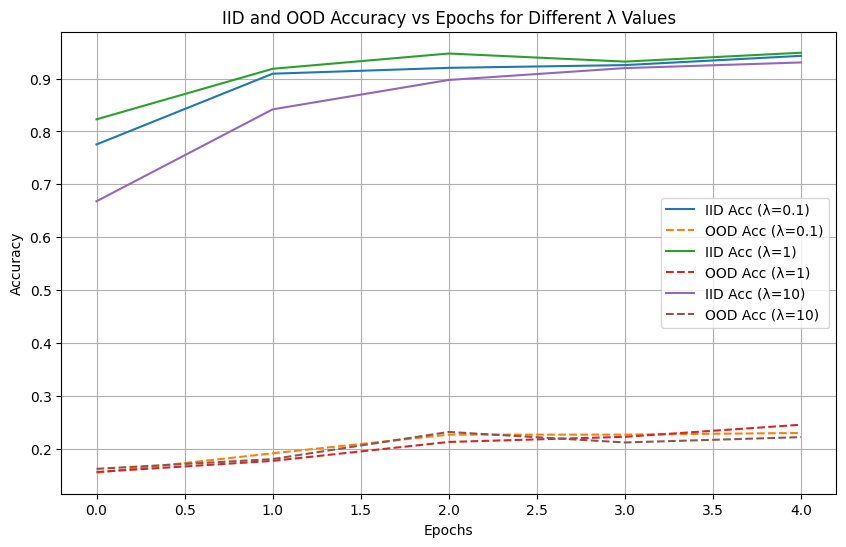

In [70]:
import matplotlib.pyplot as plt

# Function to train with different lambda_irm values and collect the accuracies
def train_and_plot_lambdas(model, train_envs, test_env, epochs, lr, lambda_vals):
    all_iid_accuracies = {}
    all_ood_accuracies = {}
    
    for lambda_irm in lambda_vals:
        model = SimpleIRMModel().to(device)
        print(f"Training with lambda_irm = {lambda_irm}")
        iid_accuracies, ood_accuracies = train_irm_basic(
            model, train_envs, test_env, epochs, lr, lambda_irm
        )
        all_iid_accuracies[lambda_irm] = iid_accuracies
        all_ood_accuracies[lambda_irm] = ood_accuracies
    
    # Plot the results
    plt.figure(figsize=(10, 6))

    for lambda_irm in lambda_vals:
        plt.plot(all_iid_accuracies[lambda_irm], label=f"IID Acc (λ={lambda_irm})")
        plt.plot(all_ood_accuracies[lambda_irm], label=f"OOD Acc (λ={lambda_irm})", linestyle='--')

    plt.title("IID and OOD Accuracy vs Epochs for Different λ Values")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define lambda values you want to test
lambda_vals = [0.1, 1, 10]

# Assuming 'model' is your trained model and other parameters are set
train_and_plot_lambdas(model, train_envs, test_env, epochs=5, lr=0.001, lambda_vals=lambda_vals)


In [71]:
# IRM Penalty (unchanged)
def irm_penalty(logits, labels):
    scale = torch.tensor(1.0, requires_grad=True).to(logits.device)
    loss = nn.CrossEntropyLoss()(logits * scale, labels)
    grad = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad ** 2)

# Variance Regularization
def compute_variance(features):
    mean = features.mean(dim=0, keepdim=True)
    variance = ((features - mean) ** 2).mean()
    return variance

# Feature Extraction for Variance (updated for SimpleIRMModel)
def extract_features(model, x):
    x = model.feature_extractor(x)  # Use the feature extractor part of the model
    return x.view(x.size(0), -1)  # Flatten the features for variance computation

# Training Function with IRM and Variance Regularization
def train_ib_irm(model, train_envs, test_env, epochs, lr, lambda_irm, gamma_var, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    iid_accuracies, ood_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_penalty = 0.0
        epoch_variance = 0.0
        total_correct_iid, total_samples_iid = 0, 0

        print(f"Epoch {epoch+1}/{epochs}")
        with tqdm(total=sum(len(env) for env in train_envs), desc="Training", unit="batch") as pbar:
            for env in train_envs:
                for images, labels in env:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    logits = model(images)

                    # IRM Loss
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)
                    penalty = irm_penalty(logits, labels)

                    # Variance Regularization
                    features = extract_features(model, images)
                    variance = compute_variance(features)

                    # Total Loss
                    loss = erm_loss + lambda_irm * penalty + gamma_var * variance
                    loss.backward()
                    optimizer.step()

                    # Metrics
                    epoch_loss += loss.item()
                    epoch_penalty += penalty.item()
                    epoch_variance += variance.item()
                    total_correct_iid += (logits.argmax(1) == labels).sum().item()
                    total_samples_iid += labels.size(0)

                    # Update progress bar
                    pbar.update(1)
                    pbar.set_postfix(
                        loss=f"{loss.item():.4f}",
                        penalty=f"{penalty.item():.4f}",
                        variance=f"{variance.item():.4f}"
                    )

        # Compute IID Accuracy
        # iid_accuracy = total_correct_iid / total_samples_iid
        val_accuracy, val_loss = evaluate_on_env(model, val_env, device)
        
        iid_accuracies.append(val_accuracy)
        # iid_accuracies.append(iid_accuracy)

        # Evaluate on test data (OOD)
        model.eval()
        total_correct_ood, total_samples_ood = 0, 0
        epoch_test_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(test_env), desc="Evaluating", unit="batch") as pbar_eval:
                for images, labels in test_env:
                    images, labels = images.to(device), labels.to(device)
                    logits = model(images)
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)
                    epoch_test_loss += erm_loss.item()
                    total_correct_ood += (logits.argmax(1) == labels).sum().item()
                    total_samples_ood += labels.size(0)
                    pbar_eval.update(1)

        ood_accuracy = total_correct_ood / total_samples_ood
        ood_accuracies.append(ood_accuracy)

        # Print epoch summary
        print(
            f"Epoch {epoch+1} Summary:\n"
            f"IID Accuracy: {val_accuracy:.4f}, OOD Accuracy: {ood_accuracy:.4f}\n"
            f"Train Loss: {val_loss:.4f}, Train Variance: {epoch_variance/total_samples_iid:.4f}\n"
            f"Test Loss: {epoch_test_loss/total_samples_ood:.4f}"
        )

    return iid_accuracies, ood_accuracies

In [72]:
# Initialize model and train IB-IRM
gamma_var = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleIRMModel().to(device)
epochs = 5
iid_accuracies_ib_irm, ood_accuracies_ib_irm = train_ib_irm(model, train_envs, test_env, epochs, lr, lambda_irm, gamma_var, device)

Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.29batch/s]


Epoch 1 Summary:
IID Accuracy: 0.8273, OOD Accuracy: 0.1502
Train Loss: 0.0043, Train Variance: 0.0009
Test Loss: 0.0309
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.65batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8746, OOD Accuracy: 0.2141
Train Loss: 0.0030, Train Variance: 0.0006
Test Loss: 0.0265
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.91batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9059, OOD Accuracy: 0.2324
Train Loss: 0.0023, Train Variance: 0.0005
Test Loss: 0.0254
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.91batch/s]


Epoch 4 Summary:
IID Accuracy: 0.8978, OOD Accuracy: 0.2410
Train Loss: 0.0024, Train Variance: 0.0004
Test Loss: 0.0267
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.05batch/s]

Epoch 5 Summary:
IID Accuracy: 0.9254, OOD Accuracy: 0.2455
Train Loss: 0.0018, Train Variance: 0.0003
Test Loss: 0.0258


In [73]:
# # Initialize model and train IB-IRM
# gamma_var = 0.5
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SimpleIRMModel().to(device)
# epochs = 5
# iid_accuracies_ib_irm, ood_accuracies_ib_irm = train_ib_irm(model, train_envs, test_env, epochs, lr, lambda_irm, gamma_var, device)

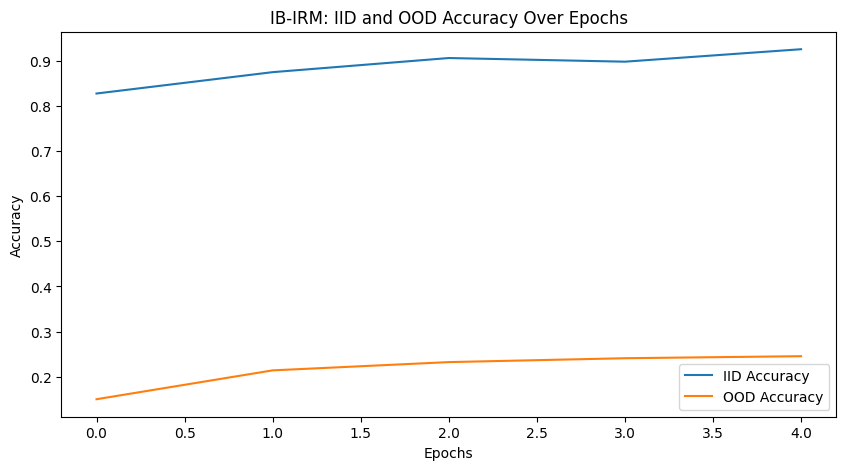

/tmp/ipykernel_23/305389624.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Epochs")


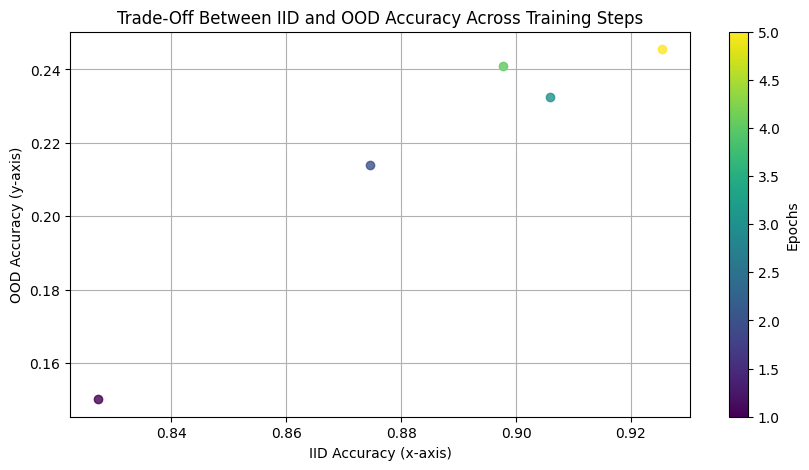

In [74]:
# Plot Results: IID vs OOD Accuracy
plt.figure(figsize=(10, 5))
plt.plot(iid_accuracies_ib_irm, label='IID Accuracy')
plt.plot(ood_accuracies_ib_irm, label='OOD Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('IB-IRM: IID and OOD Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot IID vs OOD Trade-off
epochs = len(iid_accuracies_ib_irm)
colors = plt.cm.viridis(np.linspace(0, 1, epochs))  # Color gradient from blue to yellow

plt.figure(figsize=(10, 5))

# Plot OOD vs IID accuracy
for i in range(epochs):
    plt.scatter(iid_accuracies_ib_irm[i], ood_accuracies_ib_irm[i], color=colors[i], label=f"Epoch {i+1}" if i == 0 else "", alpha=0.8)

# Add labels and title
plt.xlabel('IID Accuracy (x-axis)')
plt.ylabel('OOD Accuracy (y-axis)')
plt.title('Trade-Off Between IID and OOD Accuracy Across Training Steps')

# Add colorbar for epochs
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=1, vmax=epochs))
sm.set_array([])
plt.colorbar(sm, label="Epochs")

# Display grid and plot
plt.grid(True)
plt.show()

Training with gamma_var = 0.01
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.52batch/s]


Epoch 1 Summary:
IID Accuracy: 0.8232, OOD Accuracy: 0.1498
Train Loss: 0.0042, Train Variance: 0.0015
Test Loss: 0.0362
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.47batch/s]


Epoch 2 Summary:
IID Accuracy: 0.9214, OOD Accuracy: 0.2067
Train Loss: 0.0019, Train Variance: 0.0021
Test Loss: 0.0305
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.04batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9192, OOD Accuracy: 0.1929
Train Loss: 0.0020, Train Variance: 0.0024
Test Loss: 0.0308
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.84batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9363, OOD Accuracy: 0.2139
Train Loss: 0.0016, Train Variance: 0.0025
Test Loss: 0.0315
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.56batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9535, OOD Accuracy: 0.2466
Train Loss: 0.0012, Train Variance: 0.0027
Test Loss: 0.0294
Training with gamma_var = 0.1
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.12batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7793, OOD Accuracy: 0.1593
Train Loss: 0.0054, Train Variance: 0.0018
Test Loss: 0.0339
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.97batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8936, OOD Accuracy: 0.1897
Train Loss: 0.0025, Train Variance: 0.0017
Test Loss: 0.0299
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.38batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8779, OOD Accuracy: 0.2219
Train Loss: 0.0028, Train Variance: 0.0015
Test Loss: 0.0293
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.54batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9226, OOD Accuracy: 0.2322
Train Loss: 0.0018, Train Variance: 0.0014
Test Loss: 0.0273
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.72batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9323, OOD Accuracy: 0.2353
Train Loss: 0.0016, Train Variance: 0.0013
Test Loss: 0.0279
Training with gamma_var = 1
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.74batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7765, OOD Accuracy: 0.1455
Train Loss: 0.0053, Train Variance: 0.0006
Test Loss: 0.0323
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 39.53batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8943, OOD Accuracy: 0.2000
Train Loss: 0.0027, Train Variance: 0.0004
Test Loss: 0.0274
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.34batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9225, OOD Accuracy: 0.2160
Train Loss: 0.0020, Train Variance: 0.0003
Test Loss: 0.0266
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.07batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9125, OOD Accuracy: 0.2323
Train Loss: 0.0021, Train Variance: 0.0002
Test Loss: 0.0258
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.05batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9274, OOD Accuracy: 0.2411
Train Loss: 0.0019, Train Variance: 0.0002
Test Loss: 0.0252
Training with gamma_var = 10
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.52batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7222, OOD Accuracy: 0.1104
Train Loss: 0.0065, Train Variance: 0.0001
Test Loss: 0.0300
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.73batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8464, OOD Accuracy: 0.1939
Train Loss: 0.0039, Train Variance: 0.0001
Test Loss: 0.0268
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 39.55batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8376, OOD Accuracy: 0.2226
Train Loss: 0.0039, Train Variance: 0.0001
Test Loss: 0.0252
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.41batch/s]


Epoch 4 Summary:
IID Accuracy: 0.8702, OOD Accuracy: 0.2259
Train Loss: 0.0033, Train Variance: 0.0000
Test Loss: 0.0247
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 40.09batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9000, OOD Accuracy: 0.2364
Train Loss: 0.0026, Train Variance: 0.0000
Test Loss: 0.0237


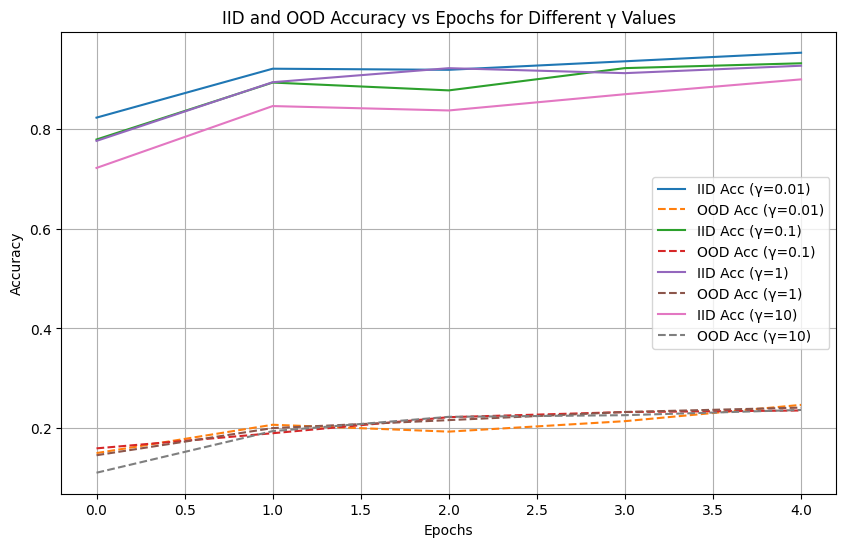

In [75]:
import matplotlib.pyplot as plt

# Function to train with varying gamma values and collect the accuracies
def train_and_plot_gamma(train_envs, test_env, epochs, lr, lambda_irm, gamma_vals, device, model_class):
    all_iid_accuracies = {}
    all_ood_accuracies = {}
    
    for gamma_var in gamma_vals:
        print(f"Training with gamma_var = {gamma_var}")
        
        # Reinitialize the model for each gamma value
        model = model_class().to(device)  # Reset the model to its initial state
        iid_accuracies, ood_accuracies = train_ib_irm(
            model, train_envs, test_env, epochs, lr, lambda_irm, gamma_var, device
        )
        
        all_iid_accuracies[gamma_var] = iid_accuracies
        all_ood_accuracies[gamma_var] = ood_accuracies
    
    # Plot the results
    plt.figure(figsize=(10, 6))

    for gamma_var in gamma_vals:
        plt.plot(all_iid_accuracies[gamma_var], label=f"IID Acc (γ={gamma_var})")
        plt.plot(all_ood_accuracies[gamma_var], label=f"OOD Acc (γ={gamma_var})", linestyle='--')

    plt.title("IID and OOD Accuracy vs Epochs for Different γ Values")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Define gamma values you want to test
gamma_vals = [0.01, 0.1, 1, 10]
lambda_irm = 0.5  # Set fixed lambda value
epochs = 5
lr = 0.001  # Learning rate

# Assuming 'SimpleIRMModel' is your custom model class
# Assuming 'train_envs' and 'test_env' are your environments
# 'device' is set to either 'cuda' or 'cpu'
train_and_plot_gamma(train_envs, test_env, epochs, lr, lambda_irm, gamma_vals, device, SimpleIRMModel)


In [89]:
for gamma in gamma_vals:
    print(f"Gamma Value = {gamma}")
    print(f" - Final IID Accuracy: {all_iid_accuracies[gamma][-1]}")
    print(f" - Final OOD Accuracy: {all_ood_accuracies[gamma][-1]}")

Gamma Value = 0.01


NameError: name 'all_iid_accuracies' is not defined

In [76]:
def train_pair_irm(model, train_envs, test_env, epochs, lr, lambda_irm, gamma_var, w1, w2, w3, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    iid_accuracies, ood_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_penalty = 0.0
        epoch_variance = 0.0
        total_correct_iid, total_samples_iid = 0, 0

        print(f"Epoch {epoch+1}/{epochs}")
        with tqdm(total=sum(len(env) for env in train_envs), desc="Training", unit="batch") as pbar:
            for env in train_envs:
                for images, labels in env:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    logits = model(images)

                    # ERM Loss (CrossEntropy)
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)

                    # IRM Loss (IRM Penalty) and multiply by lambda_irm
                    penalty = irm_penalty(logits, labels)
                    irm_loss = lambda_irm * penalty

                    # Variance Regularization Loss and multiply by gamma_var
                    features = extract_features(model, images)
                    variance = compute_variance(features)
                    var_loss = gamma_var * variance

                    # Total Loss (Weighted sum of the three components)
                    total_loss = w1 * erm_loss + w2 * irm_loss + w3 * var_loss
                    total_loss.backward()
                    optimizer.step()

                    # Metrics
                    epoch_loss += total_loss.item()
                    epoch_penalty += penalty.item()
                    epoch_variance += variance.item()
                    total_correct_iid += (logits.argmax(1) == labels).sum().item()
                    total_samples_iid += labels.size(0)

                    # Update progress bar
                    pbar.update(1)
                    pbar.set_postfix(
                        loss=f"{total_loss.item():.4f}",
                        penalty=f"{penalty.item():.4f}",
                        variance=f"{variance.item():.4f}"
                    )

        # Compute IID Accuracy
        # iid_accuracy = total_correct_iid / total_samples_iid
        # iid_accuracies.append(iid_accuracy)
        val_accuracy, val_loss = evaluate_on_env(model, val_env, device)
        
        iid_accuracies.append(val_accuracy)

        # Evaluate on test data (OOD)
        model.eval()
        total_correct_ood, total_samples_ood = 0, 0
        epoch_test_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(test_env), desc="Evaluating", unit="batch") as pbar_eval:
                for images, labels in test_env:
                    images, labels = images.to(device), labels.to(device)
                    logits = model(images)
                    erm_loss = nn.CrossEntropyLoss()(logits, labels)
                    epoch_test_loss += erm_loss.item()
                    total_correct_ood += (logits.argmax(1) == labels).sum().item()
                    total_samples_ood += labels.size(0)
                    pbar_eval.update(1)

        ood_accuracy = total_correct_ood / total_samples_ood
        ood_accuracies.append(ood_accuracy)

        # Print epoch summary
        print(
            f"Epoch {epoch+1} Summary:\n"
            f"IID Accuracy: {val_accuracy:.4f}, OOD Accuracy: {ood_accuracy:.4f}\n"
            f"Train Loss: {val_loss:.4f}, Train Variance: {epoch_variance/total_samples_iid:.4f}\n"
            f"Test Loss: {epoch_test_loss/total_samples_ood:.4f}"
        )

    return iid_accuracies, ood_accuracies

In [77]:
# # Example parameters
# lambda_irm = 0.5  # IRM regularization strength
# gamma_var = 0.5   # Variance regularization strength
# w1 = 1         # Weight for ERM loss
# w2 = 1         # Weight for IRM penalty
# w3 = 1        # Weight for variance regularization
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Initialize the model
# model = SimpleIRMModel().to(device)

# # Train the model with the selected parameters
# iid_accuracies, ood_accuracies = train_pair_irm(
#     model, train_envs, test_env, epochs=5, lr=0.0001, 
#     lambda_irm=lambda_irm, gamma_var=gamma_var, w1=w1, w2=w2, w3=w3, device=device
# )

In [83]:
# Example parameters
lambda_irm = 0.5  # IRM regularization strength
gamma_var = 0.5   # Variance regularization strength
w1 = 1.5          # Weight for ERM loss
w2 = 1        # Weight for IRM penalty
w3 = 2          # Weight for variance regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = SimpleIRMModel().to(device)

# Train the model with the selected parameters
iid_accuracies, ood_accuracies = train_pair_irm(
    model, train_envs, test_env, epochs=5, lr=0.001, 
    lambda_irm=lambda_irm, gamma_var=gamma_var, w1=w1, w2=w2, w3=w3, device=device
)

Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.71batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7787, OOD Accuracy: 0.1384
Train Loss: 0.0053, Train Variance: 0.0007
Test Loss: 0.0326
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.36batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8988, OOD Accuracy: 0.1769
Train Loss: 0.0025, Train Variance: 0.0005
Test Loss: 0.0308
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.04batch/s]


Epoch 3 Summary:
IID Accuracy: 0.9215, OOD Accuracy: 0.2193
Train Loss: 0.0020, Train Variance: 0.0004
Test Loss: 0.0273
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.78batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9273, OOD Accuracy: 0.2392
Train Loss: 0.0017, Train Variance: 0.0003
Test Loss: 0.0273
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.40batch/s]

Epoch 5 Summary:
IID Accuracy: 0.9181, OOD Accuracy: 0.2539
Train Loss: 0.0021, Train Variance: 0.0003
Test Loss: 0.0261


Running with weights: w1=1.5, w2=0.5, w3=0.5
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.82batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7313, OOD Accuracy: 0.1449
Train Loss: 0.0062, Train Variance: 0.0004
Test Loss: 0.0290
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.18batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8530, OOD Accuracy: 0.1914
Train Loss: 0.0038, Train Variance: 0.0010
Test Loss: 0.0273
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.24batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8973, OOD Accuracy: 0.2210
Train Loss: 0.0027, Train Variance: 0.0012
Test Loss: 0.0259
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.21batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9101, OOD Accuracy: 0.2315
Train Loss: 0.0023, Train Variance: 0.0013
Test Loss: 0.0255
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 39.71batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9248, OOD Accuracy: 0.2456
Train Loss: 0.0019, Train Variance: 0.0014
Test Loss: 0.0256
Running with weights: w1=1.0, w2=2.0, w3=0.5
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.33batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7094, OOD Accuracy: 0.1397
Train Loss: 0.0069, Train Variance: 0.0004
Test Loss: 0.0387
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:01<00:00, 39.86batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8390, OOD Accuracy: 0.1572
Train Loss: 0.0041, Train Variance: 0.0009
Test Loss: 0.0365
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.89batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8728, OOD Accuracy: 0.1864
Train Loss: 0.0032, Train Variance: 0.0011
Test Loss: 0.0327
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.99batch/s]


Epoch 4 Summary:
IID Accuracy: 0.8988, OOD Accuracy: 0.1986
Train Loss: 0.0026, Train Variance: 0.0012
Test Loss: 0.0311
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.48batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9157, OOD Accuracy: 0.2068
Train Loss: 0.0022, Train Variance: 0.0012
Test Loss: 0.0298
Running with weights: w1=1.0, w2=1.0, w3=2.0
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.08batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7322, OOD Accuracy: 0.1368
Train Loss: 0.0063, Train Variance: 0.0004
Test Loss: 0.0360
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.98batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8454, OOD Accuracy: 0.1765
Train Loss: 0.0038, Train Variance: 0.0008
Test Loss: 0.0305
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.13batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8836, OOD Accuracy: 0.1986
Train Loss: 0.0030, Train Variance: 0.0008
Test Loss: 0.0283
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.58batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9093, OOD Accuracy: 0.2271
Train Loss: 0.0025, Train Variance: 0.0007
Test Loss: 0.0275
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.32batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9182, OOD Accuracy: 0.2220
Train Loss: 0.0023, Train Variance: 0.0007
Test Loss: 0.0274
Running with weights: w1=1.0, w2=1.0, w3=1.0
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.90batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7138, OOD Accuracy: 0.1515
Train Loss: 0.0065, Train Variance: 0.0004
Test Loss: 0.0321
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 39.02batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8586, OOD Accuracy: 0.1878
Train Loss: 0.0036, Train Variance: 0.0010
Test Loss: 0.0309
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.86batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8951, OOD Accuracy: 0.1986
Train Loss: 0.0027, Train Variance: 0.0010
Test Loss: 0.0292
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 38.00batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9108, OOD Accuracy: 0.1965
Train Loss: 0.0024, Train Variance: 0.0010
Test Loss: 0.0292
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.49batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9231, OOD Accuracy: 0.2058
Train Loss: 0.0021, Train Variance: 0.0010
Test Loss: 0.0285
Running with weights: w1=2.0, w2=0.5, w3=0.5
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.11batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7492, OOD Accuracy: 0.1352
Train Loss: 0.0060, Train Variance: 0.0004
Test Loss: 0.0259
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.46batch/s]


Epoch 2 Summary:
IID Accuracy: 0.8573, OOD Accuracy: 0.1927
Train Loss: 0.0036, Train Variance: 0.0010
Test Loss: 0.0256
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.94batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8817, OOD Accuracy: 0.2083
Train Loss: 0.0030, Train Variance: 0.0013
Test Loss: 0.0250
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.55batch/s]


Epoch 4 Summary:
IID Accuracy: 0.9076, OOD Accuracy: 0.2243
Train Loss: 0.0024, Train Variance: 0.0014
Test Loss: 0.0247
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 34.86batch/s]


Epoch 5 Summary:
IID Accuracy: 0.9255, OOD Accuracy: 0.2389
Train Loss: 0.0019, Train Variance: 0.0014
Test Loss: 0.0245
Running with weights: w1=0.5, w2=2.0, w3=0.5
Epoch 1/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 37.34batch/s]


Epoch 1 Summary:
IID Accuracy: 0.7106, OOD Accuracy: 0.1316
Train Loss: 0.0067, Train Variance: 0.0004
Test Loss: 0.0283
Epoch 2/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.95batch/s]


Epoch 2 Summary:
IID Accuracy: 0.7901, OOD Accuracy: 0.1396
Train Loss: 0.0049, Train Variance: 0.0012
Test Loss: 0.0313
Epoch 3/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.85batch/s]


Epoch 3 Summary:
IID Accuracy: 0.8357, OOD Accuracy: 0.1653
Train Loss: 0.0039, Train Variance: 0.0013
Test Loss: 0.0298
Epoch 4/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 35.75batch/s]


Epoch 4 Summary:
IID Accuracy: 0.8701, OOD Accuracy: 0.1815
Train Loss: 0.0033, Train Variance: 0.0012
Test Loss: 0.0289
Epoch 5/5


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 36.27batch/s]


Epoch 5 Summary:
IID Accuracy: 0.8930, OOD Accuracy: 0.1823
Train Loss: 0.0027, Train Variance: 0.0012
Test Loss: 0.0282


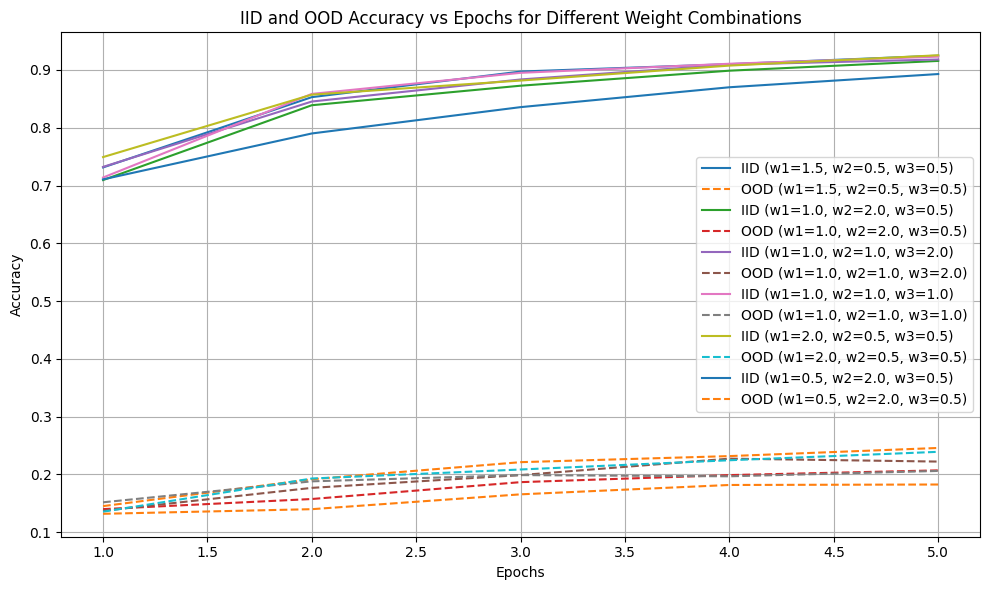

In [79]:
import matplotlib.pyplot as plt

# Define the different weight combinations to test
weight_combos = [
    {'w1': 1.5, 'w2': 0.5, 'w3': 0.5},  # Baseline (balanced)
    {'w1': 1.0, 'w2': 2.0, 'w3': 0.5},  # Strong IRM emphasis
    {'w1': 1.0, 'w2': 1.0, 'w3': 2.0},  # Strong variance regularization
    {'w1': 1.0, 'w2': 1.0, 'w3': 1.0},  # Balanced
    {'w1': 2.0, 'w2': 0.5, 'w3': 0.5},  # Heavy emphasis on classification accuracy
    {'w1': 0.5, 'w2': 2.0, 'w3': 0.5},  # Heavy emphasis on IRM
]

# Store results to plot
results = []

for combo in weight_combos:
    print(f"Running with weights: w1={combo['w1']}, w2={combo['w2']}, w3={combo['w3']}")
    model = SimpleIRMModel().to(device)
    # Train the model with the current weight combination
    iid_accuracies, ood_accuracies = train_pair_irm(
        model, train_envs, test_env, epochs=5, lr=0.0001, 
        lambda_irm=lambda_irm, gamma_var=gamma_var, 
        w1=combo['w1'], w2=combo['w2'], w3=combo['w3'], device=device
    )
    
    # Store the results
    results.append({
        'w1': combo['w1'],
        'w2': combo['w2'],
        'w3': combo['w3'],
        'iid_accuracies': iid_accuracies,
        'ood_accuracies': ood_accuracies
    })

# Plotting IID and OOD accuracies
plt.figure(figsize=(10, 6))

for result in results:
    plt.plot(range(1, 6), result['iid_accuracies'], label=f"IID (w1={result['w1']}, w2={result['w2']}, w3={result['w3']})")
    plt.plot(range(1, 6), result['ood_accuracies'], label=f"OOD (w1={result['w1']}, w2={result['w2']}, w3={result['w3']})", linestyle='--')

# Adding labels and title
plt.title('IID and OOD Accuracy vs Epochs for Different Weight Combinations')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
for result in results:
    print(f"Results for w1={result['w1']}, w2={result['w2']}, w3={result['w3']}:")
    print(f" - Final IID Accuracy: {result['iid_accuracies'][-1]}")
    print(f" - Final OOD Accuracy: {result['ood_accuracies'][-1]}")

Results for w1=1.5, w2=0.5, w3=0.5:
 - Final IID Accuracy: 0.9248
 - Final OOD Accuracy: 0.2456
Results for w1=1.0, w2=2.0, w3=0.5:
 - Final IID Accuracy: 0.9157
 - Final OOD Accuracy: 0.2068
Results for w1=1.0, w2=1.0, w3=2.0:
 - Final IID Accuracy: 0.9182
 - Final OOD Accuracy: 0.222
Results for w1=1.0, w2=1.0, w3=1.0:
 - Final IID Accuracy: 0.9231
 - Final OOD Accuracy: 0.2058
Results for w1=2.0, w2=0.5, w3=0.5:
 - Final IID Accuracy: 0.9255
 - Final OOD Accuracy: 0.2389
Results for w1=0.5, w2=2.0, w3=0.5:
 - Final IID Accuracy: 0.893
 - Final OOD Accuracy: 0.1823


In [85]:
# idx = 20  # index of the digit in the training environments
# all_envs_data = train_envs_data + [test_env_data]
# angles_plus_test = train_env_angles + [test_angle]

# # Get the label of the digit at 'idx' from the first training environment
# train_img, train_label = train_envs_data[0][idx]

# # Find the first occurrence of 'train_label' in the test environment
# test_match_idx = None
# for i, (img, label) in enumerate(test_env_data):
#     if label == train_label:
#         test_match_idx = i
#         break

# fig, axes = plt.subplots(1, len(train_env_angles)+1, figsize=(12, 2))

# # Display all training environments with the exact same index
# for i, (env_data, angle) in enumerate(zip(train_envs_data, train_env_angles)):
#     img, label = env_data[idx]
#     axes[i].imshow(img, cmap='gray')
#     axes[i].set_title(f"{angle}° (Train, Label={label})")
#     axes[i].axis('off')

# # Display the matched label digit from the test environment
# if test_match_idx is not None:
#     test_img, test_label = test_env_data[test_match_idx]
#     axes[-1].imshow(test_img, cmap='gray')
#     axes[-1].set_title(f"{test_angle}° (Test, Label={test_label})")
#     axes[-1].axis('off')
# else:
#     # If no match found, just display the test image at idx=0
#     test_img, test_label = test_env_data[0]
#     axes[-1].imshow(test_img, cmap='gray')
#     axes[-1].set_title(f"{test_angle}° (Test, Label={test_label})")
#     axes[-1].axis('off')

# plt.tight_layout()
# plt.show()

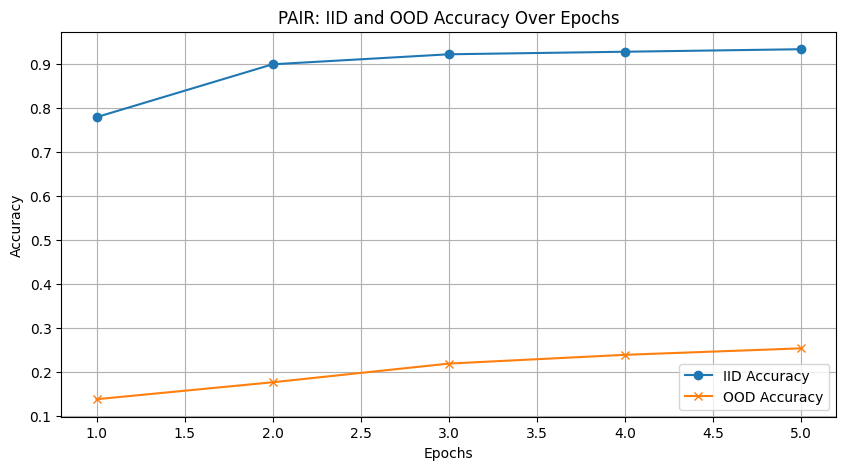

/tmp/ipykernel_23/2645026407.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Epochs")


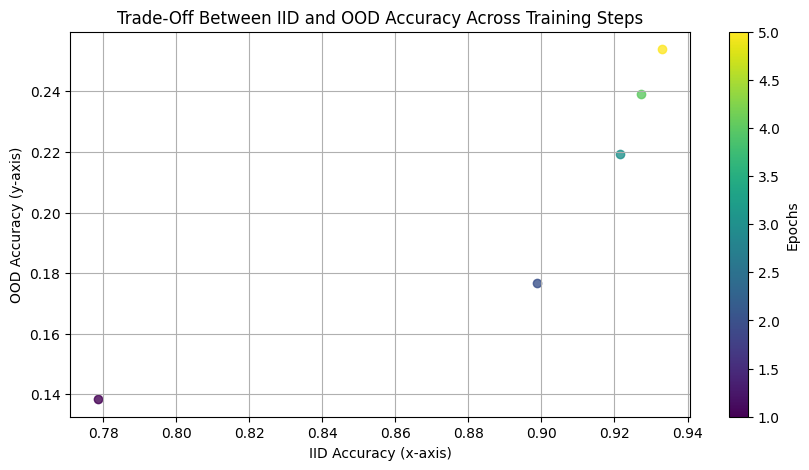

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Given values
iid_accuracies = [0.7787, 0.8988, 0.9215, 0.9273, 0.933]
ood_accuracies = [0.1384, 0.1769, 0.2193, 0.2392, 0.2539]

# Plot Results: IID vs OOD Accuracy over Epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(iid_accuracies) + 1), iid_accuracies, label='IID Accuracy', marker='o')
plt.plot(range(1, len(ood_accuracies) + 1), ood_accuracies, label='OOD Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('PAIR: IID and OOD Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot IID vs OOD Trade-off
epochs = len(iid_accuracies)
colors = plt.cm.viridis(np.linspace(0, 1, epochs))  # Color gradient from blue to yellow

plt.figure(figsize=(10, 5))

# Plot OOD vs IID accuracy
for i in range(epochs):
    plt.scatter(iid_accuracies[i], ood_accuracies[i], color=colors[i], label=f"Epoch {i+1}", alpha=0.8)

# Add labels and title
plt.xlabel('IID Accuracy (x-axis)')
plt.ylabel('OOD Accuracy (y-axis)')
plt.title('Trade-Off Between IID and OOD Accuracy Across Training Steps')

# Add colorbar for epochs
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=1, vmax=epochs))
sm.set_array([])
plt.colorbar(sm, label="Epochs")

# Display grid and plot
plt.grid(True)
plt.show()
